In [ ]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dibimbingdataset/boston.csv')
# .replace(r'^\s*$', np.nan, regex=True)
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [ ]:
df["medv"].describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

# Preparation and Multicolinearity Handling

In [ ]:
# split train test
from sklearn.model_selection import train_test_split

feature = df.drop(columns='medv')
target = df[['medv']]

feature_df_train, feature_df_test, target_df_train, target_df_test = train_test_split(feature, target, test_size=0.20, random_state=42)
feature_df_train, feature_df_validation, target_df_train, target_df_validation = train_test_split(feature_df_train, target_df_train, test_size=0.20, random_state=42)

## VIF check

In [ ]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_df_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


Following the standard taught in classroom: 
1. 5 variables found to have medium collinearity (>3): indus, nox, dis, rad, tax

## Correlation Heatmap Check

We will decide which variables to drop using corr heatmap with the following decision standard: 
* when the corr is > 0.8 then we will drop one of the variable

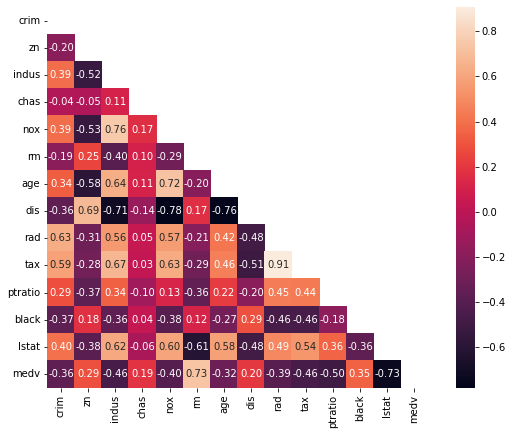

In [ ]:
# heatmap correlation
df_train = pd.concat([feature_df_train, target_df_train], axis=1)
corr = df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f', mask = mask, square=True)
plt.show()

from heatmap correlation map, identify variables with absolute correlation larger than 0.8
1. tax & rad are highly correlated with r value of -> 0.91, we need to only pick 1 and drop the other

other variables are below the 0.8 standard so we keep them as is

decision: since tax has higher correlation with target variable (medv) compared to rad, hence we choose to keep tax and drop rad

We choose to retain `tax`. Therefore, we need to drop:
* `rad`

In [ ]:
# drop redundant features
feature_df_train = feature_df_train.drop(columns=['rad'])
feature_df_test = feature_df_test.drop(columns=['rad'])
feature_df_validation = feature_df_validation.drop(columns=['rad'])

## Recheck VIF

In [ ]:
# re-calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_df_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,1.615076
2,zn,2.415036
3,indus,3.500250
4,chas,1.097962
5,nox,4.552308
6,rm,1.923266
7,age,3.119817
8,dis,4.390362
9,tax,3.191363
10,ptratio,1.804558


Results is better no VIF higher than 7 now, and since there is no variables with correlation higher than 0.8 we will not drop any more variable

# Model Training


## Ridge

In [ ]:
from sklearn.linear_model import Ridge

# train the model
X_df_train = feature_df_train.to_numpy()
y_df_train = target_df_train.to_numpy()
y_df_train = y_df_train.reshape(len(y_df_train),)

# define the model
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_df_train, y_df_train)
ridge_reg_pointone.fit(X_df_train, y_df_train)
ridge_reg_one.fit(X_df_train, y_df_train)
ridge_reg_ten.fit(X_df_train, y_df_train)

Ridge(alpha=10, random_state=42)

### Choose Best Model using RMSE

In [ ]:
from sklearn.metrics import mean_squared_error

X_df_validation = feature_df_validation.to_numpy()
y_df_validation = target_df_validation.to_numpy()
y_df_validation = y_df_validation.reshape(len(y_df_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_df_validation)
    rmse = np.sqrt(mean_squared_error(y_df_validation,y_predict_validation))
    print('RMSE of Ridge regression model with alpha = {:.3f} is {:.3f}'.format(alpha, rmse))

RMSE of Ridge regression model with alpha = 0.010 is 4.961
RMSE of Ridge regression model with alpha = 0.100 is 4.949
RMSE of Ridge regression model with alpha = 1.000 is 4.912
RMSE of Ridge regression model with alpha = 10.000 is 4.872


Best model for Ridge regression is when alpha = 10.000, with lowest RMSE as the metrics of evaluation

### Coefficient for Best Model

We now look at the coefficient of the model with best lambda

In [ ]:
# retrieve the coefficients
# show as a nice dataframe

data = feature_df_train
model = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,15.064666
1,crim,-0.071408
2,zn,0.033030
3,indus,-0.067858
4,chas,1.955801
5,nox,-1.568248
6,rm,4.783168
7,age,-0.011523
8,dis,-1.260056
9,tax,-0.001976


### Interpretation for Best Model

```
medv = 15.064666 
- 0.071408 * crim + 0.033030 * zn -0.067858 * indus 
+ 1.955801 * chas - 1.568248 * nox + 4.783168 * rm 
- 0.011523 * age - 1.260056 * dis - 0.001976 * tax 
- 0.697550 *pratio + 0.012729 * black - 0.523827 * lstat
```

* For every 1 point `increase` in variable `rm` - average number of room per dwelling, (assuming other variables do not change), it has an association with an `increase` of 4.783168 point in median value `medv` (in USD 1000's). 
* For every 1 point `increase` in variable `pratio` - pupil teacher ratio in the neighborhood, assuming other variables do not change, it has an association with a `decrease` of 0.697550 point in median value `medv` (in USD 1000's)

## Lasso

In [ ]:
from sklearn.linear_model import Lasso

# train the model
X_df_train = feature_df_train.to_numpy()
y_df_train = target_df_train.to_numpy()
y_df_train = y_df_train.reshape(len(y_df_train),)

# define the model
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_df_train, y_df_train)
lasso_reg_pointone.fit(X_df_train, y_df_train)
lasso_reg_one.fit(X_df_train, y_df_train)
lasso_reg_ten.fit(X_df_train, y_df_train)

Lasso(alpha=10, random_state=42)

### Choose Best Model using RMSE

In [ ]:
from sklearn.metrics import mean_squared_error

X_df_validation = feature_df_validation.to_numpy()
y_df_validation = target_df_validation.to_numpy()
y_df_validation = y_df_validation.reshape(len(y_df_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_df_validation)
    rmse = np.sqrt(mean_squared_error(y_df_validation,y_predict_validation))
    print('RMSE of Lasso regression model with alpha = {:.3f} is {:.3f}'.format(alpha, rmse))

RMSE of Lasso regression model with alpha = 0.010 is 4.816
RMSE of Lasso regression model with alpha = 0.100 is 4.812
RMSE of Lasso regression model with alpha = 1.000 is 4.795
RMSE of Lasso regression model with alpha = 10.000 is 5.434


Best model for Lasso regression is when alpha = 0.1, with lowest RMSE as the metrics of evaluation

### Coefficient for Best Model 

We now look at the coefficient for the model with best lambda

In [ ]:
# retrieve the coefficients
# show as a nice dataframe

data = feature_df_train
model = lasso_reg_pointone

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,15.425577
1,crim,-0.075710
2,zn,0.027093
3,indus,-0.061336
4,chas,1.266833
5,nox,-0.000000
6,rm,4.564419
7,age,-0.016919
8,dis,-1.155550
9,tax,-0.002088


### Interpretation for Best Model

```
medv = 15.425577
- 0.075710 * crim + 0.027093 * zn - 0.061336 * indus 
+ 1.266833 * chas - 0.000000 * nox + 4.564419 * rm 
- 0.016919 * age - 1.155550 * dis - 0.002088 * tax 
- 0.657651 *pratio + 0.012361 * black - 0.551271 * lstat
```

* For every 1 point `increase` in variable `rm` - average number of room per dwelling, (assuming other variables do not change), it has an association with an `increase` of 4.564419 point in median value `medv` (in USD 1000's). 
* For every 1 point `increase` in variable `pratio` - pupil teacher ratio in the neighborhood, assuming other variables do not change, it has an association with a `decrease` of 0.657651 point in median value `medv` (in USD 1000's)

# Model Evaluation

## Ridge Best Model Evaluation

### Diagnostic Study

In [ ]:
from sklearn.metrics import r2_score

ridge_best = ridge_reg_ten

y_predict_train = ridge_best.predict(X_df_train)

print('R-squared for training data is {}'.format(r2_score(y_predict_train, y_df_train)))

R-squared for training data is 0.6542246087727177


### Training Error

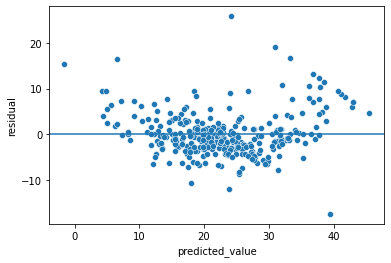

In [ ]:
# calculate residuals
residual = y_df_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()


variance of residuals seems random -> no bias in residuals

In [ ]:
# prepare prediction result on training data
y_predict_train = ridge_best.predict(X_df_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_predict_train, y_df_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_predict_train, y_df_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_predict_train, y_df_train)))

RMSE for training data is 4.778640361040111
MAE for training data is 3.3776762058865626
MAPE for training data is 0.20627342943666688


* Standard deviation of the residuals in 
the training data, is +/- 4.778640361040111 (from `RSME`)

### Testing Error

In [ ]:
# prepare prediction result on test data
X_df_test = feature_df_test.to_numpy()
y_predict_test = ridge_best.predict(X_df_test)

# ground truth target
y_df_test = target_df_test.to_numpy()
y_df_test = y_df_test.reshape(len(y_df_test),)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_predict_test, y_df_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_predict_test, y_df_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_predict_test, y_df_test)))

RMSE for testing data is 5.158908333657057
MAE for testing data is 3.2444816457044965
MAPE for testing data is 0.2622349874986081


* Standard deviation of the residuals in 
the testing data, is +/- 5.158908333657057 (from `RSME`)

### Interpretation for testing data

* Based on `MAE`, on average our prediction deviates the true `medv` value by 3.244 points (in USD 1000's) - so it is quite significant because the predication can be different in thousands of dollars 
* Based on `MAPE`, this 3.244 points deviation is equivalent to 26% of deviation relative to true `medv` value. So, the model still have relatively large deviation but we will use standard of 30% to decide the model as not acceptable, so we conclude that the model still `acceptable` to predict `medv` value. 

## Lasso Best Model Evaluation

### Diagnostic Study

In [ ]:
from sklearn.metrics import r2_score

lasso_best = lasso_reg_pointone

y_predict_train = lasso_best.predict(X_df_train)

print('R-squared for training data is {}'.format(r2_score(y_predict_train, y_df_train)))

R-squared for training data is 0.6412320625611863


64% of variance in the target `medv` is explained by all the feature in the model

### Training Error

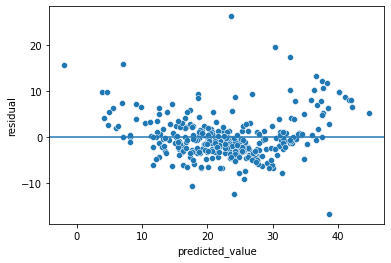

In [ ]:
# calculate residuals
residual = y_df_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

variance of residuals seems random -> no bias in residuals

### Testing Error

In [ ]:
# prepare prediction result on training data
y_predict_train = lasso_best.predict(X_df_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_predict_train, y_df_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_predict_train, y_df_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_predict_train, y_df_train)))

RMSE for training data is 4.823417811029444
MAE for training data is 3.4075152037769376
MAPE for training data is 0.20397936123738517


* Standard deviation of the residuals in 
the training data, is +/- 4.823417811029444 (from `RSME`)

In [ ]:
# prepare prediction result on test data
X_df_test = feature_df_test.to_numpy()
y_predict_test = lasso_best.predict(X_df_test)

# ground truth target
y_df_test = target_df_test.to_numpy()
y_df_test = y_df_test.reshape(len(y_df_test),)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_predict_test, y_df_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_predict_test, y_df_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_predict_test, y_df_test)))

RMSE for testing data is 5.181855076339578
MAE for testing data is 3.271163069694891
MAPE for testing data is 0.254586846782747


* Standard deviation of the residuals in 
the testing data, is +/- 45.181855076339578 (from `RSME`)

### Interpretation for testing data

* Based on `MAE`, on average our prediction deviates the true `medv` value by 3.271 points (in USD 1000's) - so it is quite significant because the prediction can be different in thousands of dollars 
* Based on `MAPE`, this 3.244 points deviation is equivalent to 25.45% of deviation relative to true `medv` value. So, the model still have relatively large deviation but we will use standard of 30% to decide the model as not acceptable, so we conclude that the model still `acceptable` to predict `medv` value. 
* Here, if we compare ridge and lasso model, lasso model performs technically speaking slightly better 25.45% vs 26% deviation compared to true `medv` value and we generally accept both model because `MAPE` is still below in 30%. 